In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#import symmetric_methods as sm


In [2]:
L=4

dim = np.zeros((L+1,))

dim[0] = 7
dim[1] = 6
dim[2] = 5
dim[3] = 6
dim[4] = 7
#dim[5] = 5

dim= dim.astype(int)

npar = 0
cpar = np.zeros((L+1,))
for iL in range(L):
    npar = npar + dim[iL] * dim[iL+1]
    cpar[iL+1] = npar
npar = npar.astype(int)
cpar = cpar.astype(int)

print(npar)
    
num_train_data = 500
num_test_data = 500

#num_train_data = 150
#num_test_data = 150

noise = 0

144


### Create Neural Network

In [3]:

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Linear(dim[0],dim[1],bias=False)]
        for iL in np.arange(1,L):
            layers.append(nn.Linear(dim[iL],dim[iL+1],bias=False))        
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)



# Define a custom initialization function using Gaussian distribution
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        # Gaussian initialization 
        y = m.in_features
        nn.init.normal_(m.weight, mean=0.0, std=1/np.sqrt(y)) 


net_teacher = Net()
net_teacher.apply(initialize_weights)

net = Net()
net.apply(initialize_weights)

net0 = Net()
net0.load_state_dict(net.state_dict())

num_parameters = sum(param.numel() for param in net.parameters())
print(num_parameters)


144


In [ ]:
# print list of all parameter tensors
print(list(net.parameters()))

### Input data

In [4]:

# Badly conditioned input

Sigma, R = np.linalg.qr(np.random.normal(np.zeros((dim[0],dim[0])),1))
Sigma = Sigma @ np.diag(np.logspace(0,-3,dim[0])) @ Sigma.T
inputs_train = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_train_data,))).to(torch.float)
inputs_test = torch.from_numpy(np.random.multivariate_normal(np.zeros((dim[0],)),Sigma,size=(num_test_data,))).to(torch.float)



### Output data

In [5]:

# teacher - student

with torch.no_grad():
    labels_train = net_teacher(inputs_train) + torch.from_numpy(noise * np.random.normal(np.zeros((num_train_data,dim[L])),1)).to(torch.float)  
with torch.no_grad():
    labels_test = net_teacher(inputs_test) + torch.from_numpy(noise * np.random.normal(np.zeros((num_test_data,dim[L])),1)).to(torch.float)




### Gradient statistics

In [6]:
N = 10000
num_updates = 10
learning_rate = 0.01

avggrad = torch.zeros(num_parameters,1)
covgrad = torch.zeros(num_parameters,num_parameters)
grad_rec = torch.zeros(num_parameters,N)

lossavg = torch.zeros(num_updates+1,)

for iN in np.arange(0,N):
    
    if (iN+1)%(N/100)==0:
        print(iN+1)
    
    net.apply(initialize_weights)

    # Forward pass
    outputs_train = net(inputs_train)

    # Compute the loss
    loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
    with torch.no_grad():
        lossavg[0] = lossavg[0] + loss

    # Compute first-order gradients (Jacobian)
    grads = torch.autograd.grad(loss, net.parameters())        
        
    for upd in range(num_updates):
        
        with torch.no_grad():  # Disable gradient computation for manual update
            for param, grad in zip(net.parameters(), grads):
                param -= learning_rate * grad
    
        outputs_train = net(inputs_train)
        loss = torch.norm(outputs_train-labels_train)**2 / num_train_data / 2
        grads = torch.autograd.grad(loss, net.parameters())
        
        with torch.no_grad():
            lossavg[upd+1] = lossavg[upd+1] + loss
    
    # Flatten gradients of all tensors (in column major order, Fortran style!)
    grad_all = torch.cat([g.T.reshape(-1,1) for g in grads])
    grad_rec[:,iN] =  torch.squeeze(grad_all)
    
    avggrad += grad_all
    covgrad += grad_all @ grad_all.T
    
avggrad /= N
covgrad /= N

lossavg /= N

covgrad = covgrad - avggrad @ avggrad.T


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


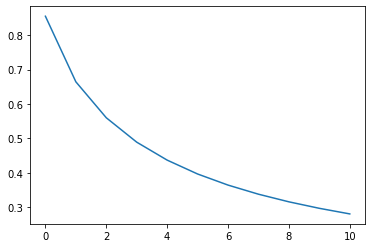

In [7]:

plt.plot(lossavg)
plt.show()


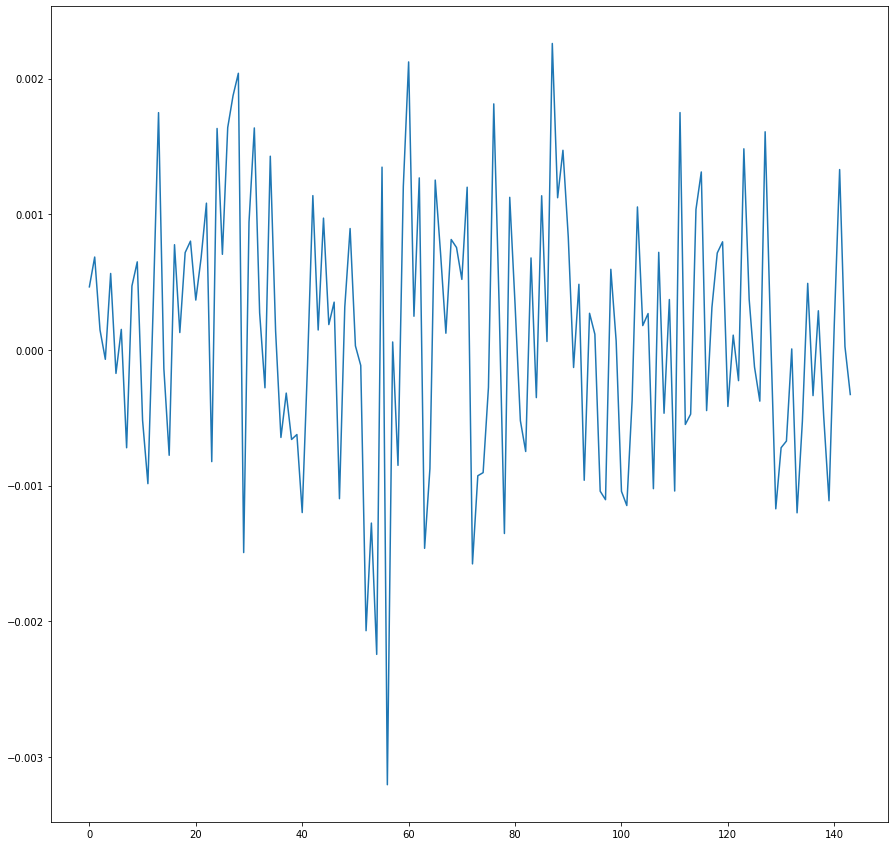

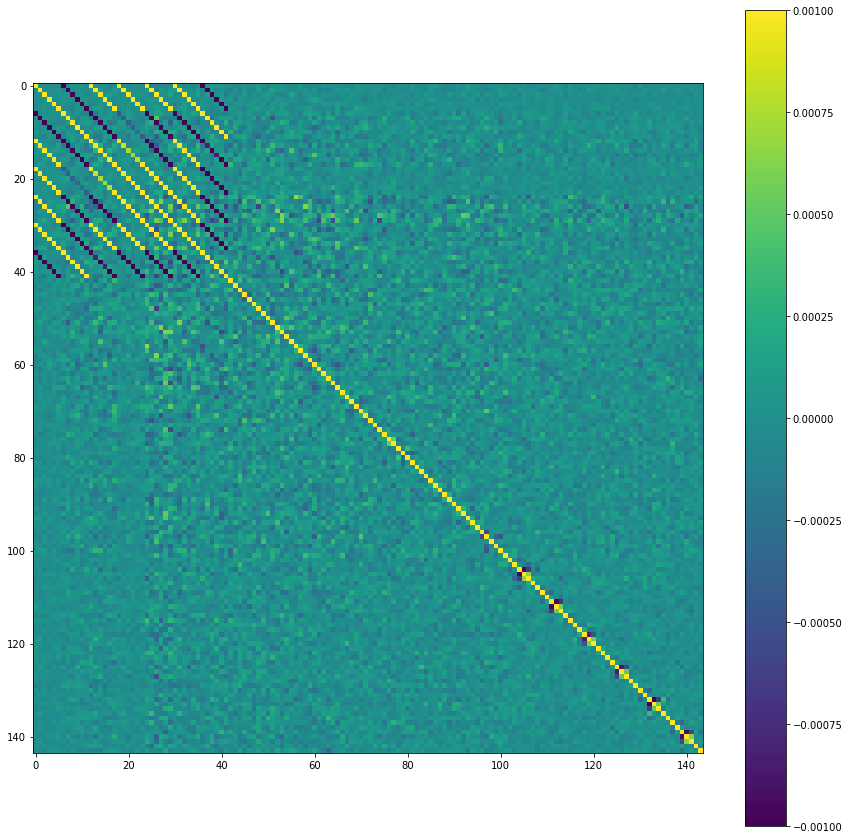

In [10]:

plt.plot(avggrad)
#plt.plot(grad_all)
fig = plt.gcf()
fig.set_size_inches(15, 15)
#plt.ylim((-10,10))
plt.show()

plt.imshow(covgrad)
plt.colorbar()
plt.clim((-0.001,0.001))
fig = plt.gcf()
fig.set_size_inches(15, 15)
plt.show()



In [ ]:

jN = 6

plt.plot(grad_rec[:,jN])
plt.show()

for iL in range(L):
    plt.imshow(np.reshape(grad_rec[cpar[iL]:cpar[iL+1],jN],(dim[iL+1],dim[iL]+1),order='F'))
    plt.colorbar()
    plt.show()






In [ ]:

wd, wt, wo = sm.cov2par(L,dim,covgrad.numpy())

print(wd)

print(wt)

print(wo)


In [ ]:

evl, evc = np.linalg.eigh(covgrad)

plt.plot(evl,linestyle='none',marker='.')
plt.yscale('log')
#plt.ylim((10**(2),10**(6)))
plt.show()

print(evl)


In [ ]:

for iL in range(L):
    print(torch.mean(grad_all[cpar[iL]:cpar[iL+1]]))


In [ ]:

covg = sm.par2cov(L,dim,wd,wt,wo)

dim_small = np.zeros((L+1,))
for iL in range(L+1):
    dim_small[iL] = 2
dim_small = dim_small.astype(int)

covg_small = sm.par2cov(L,dim_small,wd,wt,wo)






In [ ]:

plt.imshow(covg)
plt.colorbar()
plt.clim((-10000,10000))
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()


plt.imshow(covg_small)
plt.colorbar()
plt.clim((-35000,35000))
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.show()





In [ ]:

evl, evc = np.linalg.eig([[0,0,1],[0,1,0],[1,0,0]])

print(evl)

print(evc)


